**Fine-tuning the T5-base model with instruction-augmentation**

---

# Preparation

In [1]:
!pip install --upgrade transformers datasets
!pip install evaluate rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2ee6310cf2f435724de5fb6c336d89bf93faef45254a1a03d249587d2f666312
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [2]:
# Logging to HF
import os
from huggingface_hub import login

# Access the Hugging Face token from Colab secrets (as an environment variable)
hf_token = os.getenv('HF_TOKEN')

# Log in to Hugging Face with the retrieved token
login(token=hf_token)

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from torch.optim import AdamW
from evaluate import load
import random
import torch
import numpy as np


import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)
!nvidia-smi

Sun Nov 23 20:31:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Instruction-augmentation

In [21]:
# Load 2% of cnn_dailymail datasets

dataset = load_dataset("abisee/cnn_dailymail", "3.0.0", split=["train[:2%]", "validation[:2%]"])

train, validation = dataset


# Add instruction to the prompts
prompts = [
    "Summarize this article:",
    "Write a brief summary of the following news piece:",
    "Give a concise version of this report:",
    "In a few sentences, describe the main points of this text:",
    "What is this story about? Summarize below:",
    "Condense the following passage:",
    "Provide a short overview of this text."
]

def add_instruction(example):
  prompt = random.choice(prompts)
  return {
      "prompt": f"{prompt}\n\n{example["article"]}",
      "target": f"{example["highlights"]}"
  }

train_dataset = train.map(
    add_instruction,
    remove_columns=train.column_names
    )
validation_dataset = validation.map(
    add_instruction,
    remove_columns=validation.column_names
    )

print("Prompt before instruction: ", train[0]["article"])
print("-"*10)
print("Prompt after instruction: ", train_dataset[0]["prompt"])

Map:   0%|          | 0/5742 [00:00<?, ? examples/s]

Map:   0%|          | 0/267 [00:00<?, ? examples/s]

Prompt before instruction:  LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box 

# Functions

In [22]:
import os
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, EarlyStoppingCallback, TrainerCallback
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset
from evaluate import load
import numpy as np

# Finetuning function
def fine_tune(batch_size, lr, peft_config, accumulation_steps, load_saved=False, checkpoint_path=None):
    model_name = 't5-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    # Load model or resume from checkpoint
    if load_saved and checkpoint_path:
        base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        model = PeftModel.from_pretrained(base_model, checkpoint_path)
        print(f"Resuming training from checkpoint: {checkpoint_path}")
    else:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        model = get_peft_model(model, peft_config)
        print("Starting new training from scratch.")

    # Tokenize the datasets
    max_input_length = 512
    max_target_length = 128

    def preprocess_function(examples):
        inputs = [ex for ex in examples["prompt"]]
        model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

        with tokenizer.as_target_tokenizer():
            labels = tokenizer(examples["target"], max_length=max_target_length, truncation=True)

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=['prompt', 'target'])
    tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True, remove_columns=['prompt', 'target'])

    # Compute validation ROUGE-1
    rouge = load("rouge")

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
        return {"rouge-1": result["rouge1"]}

    # Defining early stopping patience
    early_stopping_patience = 3

    training_args = Seq2SeqTrainingArguments(
        output_dir=f"./temp_lr{lr}",
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=10,
        gradient_accumulation_steps=accumulation_steps,
        weight_decay=0.01,
        save_total_limit=2,
        predict_with_generate=True,
        fp16=True,
        remove_unused_columns=False,
        metric_for_best_model="rouge-1",
        greater_is_better=True,
        load_best_model_at_end=True
    )

    # Define data collator
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

    # Initialize the trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_validation_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]
    )

    # Variables to store metrics
    train_losses = []
    val_losses = []
    rouge_scores = []


    # Custom logging callback to store metrics per epoch
    class CustomLoggingCallback(TrainerCallback):
        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs is not None:
                # Check if 'epoch' key is present to identify epoch-end logs
                if 'epoch' in logs:
                    if 'loss' in logs: # Training loss is typically under 'loss' key for epoch summaries
                        train_losses.append(logs['loss'])
                    if 'eval_loss' in logs:
                        val_losses.append(logs['eval_loss'])
                    if 'eval_rouge-1' in logs:
                        rouge_scores.append(logs['eval_rouge-1'])

    # Add the custom callback
    trainer.add_callback(CustomLoggingCallback())

    # Train the model
    resume_checkpoint_path = checkpoint_path if load_saved and checkpoint_path else None
    trainer.train(resume_from_checkpoint=resume_checkpoint_path)

    eval_results = trainer.evaluate()
    print(f"Validation ROUGE-1 for lr={lr}, batch_size={batch_size}, accumulation_steps={accumulation_steps}: \n {eval_results['eval_rouge-1']}")

    # Save the model and tokenizer to Hugging Face Hub
    repo_id = "t5-base-Instruction-Fine-tuned"
    model.push_to_hub(repo_id)
    tokenizer.push_to_hub(repo_id)
    print(f"Model and tokenizer saved and pushed to Hugging Face Hub as {repo_id}")

    # Plotting the metrics
    plot_metrics(train_losses, val_losses, rouge_scores)


#setting LoRA with rate as 8
peft_config_eight = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

In [23]:
# Plotting function for Training loss, Validation loss, and ROUGE-1
import matplotlib.pyplot as plt


def plot_metrics(train_losses, val_losses, rouge_scores):


    val_losses = val_losses[:-1]
    rouge_scores = rouge_scores[:-1]

    epochs = range(1, len(train_losses) + 1)  # Assuming one metric per epoch
    plt.figure(figsize=(10, 6))

    # Plotting loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting ROUGE-1 score
    plt.subplot(2, 1, 2)
    plt.plot(epochs, rouge_scores, label='ROUGE-1', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('ROUGE-1')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Fine-Tuning

Starting new training from scratch.


Map:   0%|          | 0/5742 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/267 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3200861310.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rouge-1
1,1.988200,1.958422,0.247385
2,1.778800,1.864013,0.255615
3,1.719200,1.838229,0.258825
4,1.692900,1.824583,0.261414
5,1.682100,1.818425,0.257398
6,1.672000,1.815714,0.258777
7,1.669700,1.813433,0.258928


Validation ROUGE-1 for lr=1e-05, batch_size=4, accumulation_steps=2: 
 0.2614143760451286


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 9.86kB / 3.56MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  .../tmpp1yem09c/spiece.model: 100%|##########|  792kB /  792kB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer saved and pushed to Hugging Face Hub as t5-base-Instruction-Fine-tuned


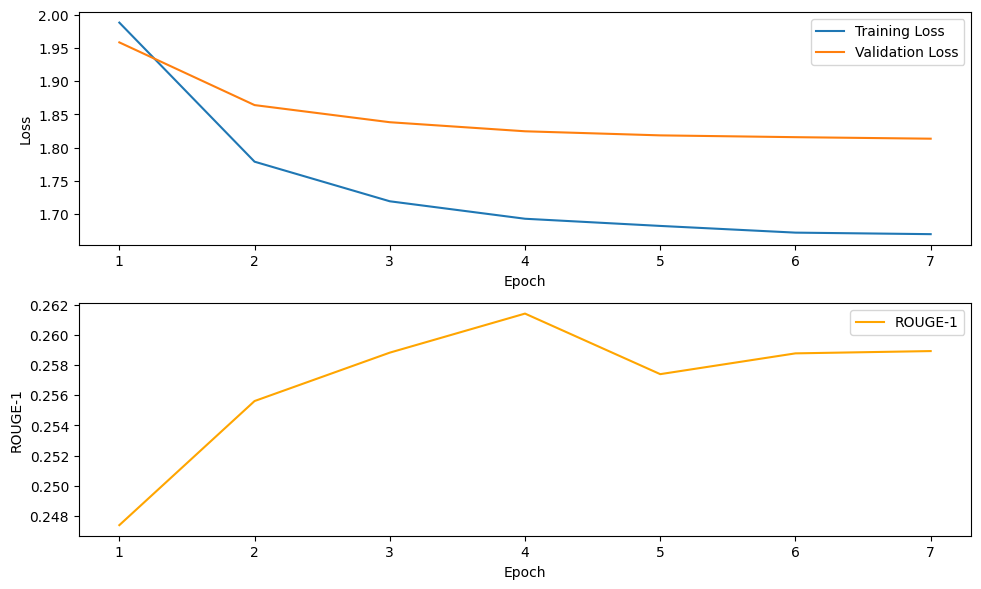

In [24]:
# Finetuning using 02_Hyperparameter_Tuning hyperparametres
fine_tune(4,1e-5,peft_config_eight,2)

> # Final Conclusion



>**Plot Observation**:

By looking at the plot, we notice that the validation loss decreased during epochs 1–4, which indicates that our model was fitting the training data well during those first few epochs. However, by epochs 5, 6, and 7, the validation loss plateaued, staying in the 1.81 range. This suggests that we are nearing the turning point, where the model will stop improving on the validation set and may start to overfit—memorizing the training data rather than generalizing to new, unseen data.



> **Why Use ROUGE-1 Instead of Validation Loss as the Stopping Criterion?**



We could have used **validation loss** to determine when to stop training (specifically, at the point where the validation loss is at its lowest). However, we chose to rely on **ROUGE-1** instead, as it is a better metric for assessing the **quality of the summarization**. ROUGE-1 measures the overlap between key words in the reference summary and the model's generated summary. It directly assesses the usefulness and relevance of the generated content.

**Validation loss** primarily measures how well the model is fitting the training data, essentially how accurately it predicts individual words or tokens. While **lower validation loss** indicates that the model is getting better at predicting words, it doesn't tell us anything about the quality of the summary. A lower validation loss doesn't necessarily mean the model is capturing important information or generating coherent, meaningful summaries.

In contrast, **ROUGE-1** evaluates how much of the important content from the original document is retained in the summary by measuring the overlap of unigrams (single words) between the reference summary and the model’s output. A higher **ROUGE-1 score** indicates better summary quality and coverage, making it a more direct measure of whether the summary is both useful and accurate.

>**Aligning ROUGE-1 and Validation Loss**:

Since the **validation loss** didn't improve much over the last three epochs, and both the **ROUGE-1** score and **validation loss** aligned well around epoch 4 (when **ROUGE-1** reached its peak and **validation loss** began to plateau), we decided to save the model at this point. We will now upload it to Hugging Face and use it for comparison with the FLAN-T5 model.

In [25]:
#Anyone can load the model and its tokenizer using "nabil1koulali/t5-base-Instruction-Fine-tuned".